In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from sklearn.metrics import mean_squared_error
import time

import matplotlib.pyplot as plt
from copy import deepcopy
from utilities_sqrt_energy import *
from matplotlib import rcParams
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 8,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 8}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 487.8225 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*0.9#*ratio  # height in inches
fig_size = [fig_width,0.7*fig_height]
rcParams.update({'figure.figsize': fig_size})

In [3]:
sns.set_context("paper")

# Training neural ODE controller with BPTT and EKI

The control problem is $\dot{x}=x+u$ with $x(t=0)=0$, $x(t=1)=1$ and minimizing $\int_0^1 u(t)^2 \, \mathrm{d}t$.

In [4]:
opt_energy = 2/(np.exp(1)**2-1)

In [51]:
T = 1
true_x0 = torch.tensor([0.0,0.0])
t = torch.linspace(0., T, 100)
target_x = torch.tensor([1])

number_layers, number_neurons = 3, 5

In [52]:
class ODE_func(nn.Module):

    def __init__(self, number_layers, number_neurons, output_control = False):
        super(ODE_func, self).__init__()

        self.input = nn.Linear(1,number_neurons)
        self.linears = nn.ModuleList([nn.Linear(number_neurons, number_neurons) for i in range(number_layers)])
        self.output = nn.Linear(number_neurons,1)
        self.number_layers = number_layers
        
        self.output_control = output_control
        
    def forward(self, t, y):
        u = self.input(torch.tensor([t]))
        
        for i in range(self.number_layers):
            u = nn.functional.elu(u)
            u = self.linears[i](u)
        u = nn.functional.elu(u)
        u = self.output(u)
        
        if self.output_control == False:
            return torch.tensor([y[0],0])+torch.tensor([1.0,0.0])*u+torch.tensor([0.0,1.0])*u*u
        else:
            return u

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.constant_(m.weight,val=1e-1)#kaiming_uniform_(m.weight)
        torch.nn.init.constant_(m.bias,val=1e-1)

In [55]:
best_params_BPTT = []
loss_arr_BP = []

eta = 0.175
lamb_arr = [1e-3,2.5e-3,5e-3,7.5e-3,1e-2]

start_time = time.time()

for lamb in lamb_arr:
    torch.manual_seed(123)
    
    loss_arr = []
    
    func = ODE_func(number_layers, number_neurons)
    func.apply(weights_init)

    pred_x = odeint(func, true_x0, t, method='dopri5')
    loss = 0.5*torch.abs(pred_x[-1] [0] - target_x)**2 + lamb*0.5*pred_x[:,1][-1]
    loss_arr.append(loss)

    optimizer = optim.Adam(func.parameters(), lr=eta)

    best_model = func
    loss_new = 1e9

    for itr in range(1, 200):

        optimizer.zero_grad()
        pred_x = odeint(func, true_x0, t, method='dopri5')
        loss = 0.5*torch.abs(pred_x[-1][0] - target_x)**2 + lamb*0.5*pred_x[:,1][-1]
        loss_arr.append(loss.detach())
        loss.backward()
        optimizer.step()

        if loss < loss_new:
            best_model = func
            loss_new = loss

        if itr % 20 == 0:
            with torch.no_grad():
                pred_x = odeint(func, true_x0, t, method='dopri5')
                loss = 0.5*torch.abs(pred_x[-1][0] - target_x)**2
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        itr += 1

    loss_arr_BP.append(loss_arr)
    best_params_BPTT.append(deepcopy(best_model))

end_time = time.time()
elapsed_time = end_time - start_time
print("time", elapsed_time)

Iter 0020 | Total Loss 0.003221
Iter 0040 | Total Loss 0.033416
Iter 0060 | Total Loss 0.001877
Iter 0080 | Total Loss 0.000395
Iter 0100 | Total Loss 0.000056
Iter 0120 | Total Loss 0.000012
Iter 0140 | Total Loss 0.000002
Iter 0160 | Total Loss 0.000001
Iter 0180 | Total Loss 0.000000
Iter 0020 | Total Loss 0.003343
Iter 0040 | Total Loss 0.032877
Iter 0060 | Total Loss 0.001800
Iter 0080 | Total Loss 0.000350
Iter 0100 | Total Loss 0.000070
Iter 0120 | Total Loss 0.000015
Iter 0140 | Total Loss 0.000004
Iter 0160 | Total Loss 0.000002
Iter 0180 | Total Loss 0.000001
Iter 0020 | Total Loss 0.003583
Iter 0040 | Total Loss 0.031795
Iter 0060 | Total Loss 0.001602
Iter 0080 | Total Loss 0.000268
Iter 0100 | Total Loss 0.000097
Iter 0120 | Total Loss 0.000021
Iter 0140 | Total Loss 0.000008
Iter 0160 | Total Loss 0.000005
Iter 0180 | Total Loss 0.000004
Iter 0020 | Total Loss 0.003878
Iter 0040 | Total Loss 0.030755
Iter 0060 | Total Loss 0.001444
Iter 0080 | Total Loss 0.000199
Iter 010

In [62]:
1/(110.62/5/200)

9.03995660820828

In [56]:
target_x = torch.tensor([1.0,0.0])

# hyperparameters EKI
number_iterations = 20
new_ensemble_members = 20
c0 = 1e-2
C0 = torch.eye(1) * c0

In [57]:
best_params_EKI = []
loss_arr_EKI = []

lamb_arr = [1e-3,2.5e-3,5e-3,7.5e-3,1e-2]

start_time = time.time()

for lamb in lamb_arr:
    torch.manual_seed(123)
    
    ensemble_members = 2
    gamma = 0.3
    Gamma = torch.eye(1) * gamma
    y = target_x.repeat(ensemble_members)
    y = y.reshape(ensemble_members,2)
    
    best_loss = 1e9
    best_params = 0
    loss_arr = []
    
    Sigma = torch.block_diag(Gamma,lamb**-1*C0)

    func_enkf = ODE_func(number_layers, number_neurons)
    nn_params = get_weights(func_enkf)

    u, F_u = generate_initial_ensemble(ODE_func, true_x0, t, ensemble_members, number_layers, number_neurons)

    min_ind = torch.argmin(0.5*(F_u[:,0]-y[:,0])**2+lamb*0.5*F_u[:,1]**2)
    loss = (0.5*(F_u[:,0]-y[:,0])**2+lamb*0.5*F_u[:,1]**2)[min_ind]
    loss_arr.append(loss)

    for n in range(number_iterations):
        #print(n,F_u[:,0].mean(),F_u[:,0].std(),F_u[:,1].mean(),F_u[:,1].std())
        #print(F_u[torch.logical_and(torch.abs(F_u[:,1]-opt_energy) <= 0.01,torch.abs(F_u[:,0]-1) <= 0.005)])
        u = update_step(u, F_u, y, Sigma, ensemble_members)

        F_u = compute_F_u(u, ODE_func, true_x0, t, ensemble_members, number_layers, number_neurons)
       
        min_ind = torch.argmin(0.5*(F_u[:,0]-y[:,0])**2+lamb*0.5*F_u[:,1]**2)
        loss = (0.5*(F_u[:,0]-y[:,0])**2+lamb*0.5*F_u[:,1]**2)[min_ind]
        loss_arr.append(loss)
        print(n,loss,F_u[min_ind][0],F_u[min_ind][1]**2)

        if loss < best_loss:
            best_loss = loss
            best_params = u[min_ind]

        if n == 2:
            gamma = 0.15
            Gamma = torch.eye(1) * gamma
            Sigma = torch.block_diag(Gamma,lamb**-1*C0)

            u, ensemble_members = add_new_ensemble_members(u, ODE_func, new_ensemble_members, number_layers, number_neurons)

            F_u = compute_F_u(u, ODE_func, true_x0, t, ensemble_members, number_layers, number_neurons)

            y = target_x.repeat(ensemble_members)
            y = y.reshape(ensemble_members,2)
        
    loss_arr_EKI.append(loss_arr)
    best_params_EKI.append(deepcopy(best_params))

end_time = time.time()
elapsed_time = end_time - start_time
print("time", elapsed_time)

0 tensor(0.5984) tensor(-0.0939) tensor(0.0032)
1 tensor(0.6032) tensor(-0.0983) tensor(0.0039)
2 tensor(0.6197) tensor(-0.1133) tensor(0.0057)
3 tensor(0.0002) tensor(0.9890) tensor(0.3330)
4 tensor(0.0002) tensor(1.0007) tensor(0.3141)
5 tensor(0.0002) tensor(0.9978) tensor(0.3123)
6 tensor(0.0002) tensor(0.9979) tensor(0.3123)
7 tensor(0.0002) tensor(0.9981) tensor(0.3124)
8 tensor(0.0002) tensor(0.9983) tensor(0.3126)
9 tensor(0.0002) tensor(0.9985) tensor(0.3127)
10 tensor(0.0002) tensor(0.9986) tensor(0.3128)
11 tensor(0.0002) tensor(0.9988) tensor(0.3129)
12 tensor(0.0002) tensor(0.9990) tensor(0.3130)
13 tensor(0.0002) tensor(0.9992) tensor(0.3131)
14 tensor(0.0002) tensor(0.9993) tensor(0.3132)
15 tensor(0.0002) tensor(0.9995) tensor(0.3133)
16 tensor(0.0002) tensor(0.9996) tensor(0.3134)
17 tensor(0.0002) tensor(0.9998) tensor(0.3135)
18 tensor(0.0002) tensor(0.9999) tensor(0.3135)
19 tensor(0.0002) tensor(1.0000) tensor(0.3136)
0 tensor(0.5984) tensor(-0.0939) tensor(0.0032)

In [63]:
1/(112.62/5/20)

0.8879417510211329

1.1129303810332303
1.0266116518807777
1.026862749771551
1.148831394108365
1.3518859755466206
0.5901537969632109
0.5055333496852565
0.5032998163651303
0.47594305101309686
0.40967506070469284


/home/lucasb/anaconda3/envs/inventory/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


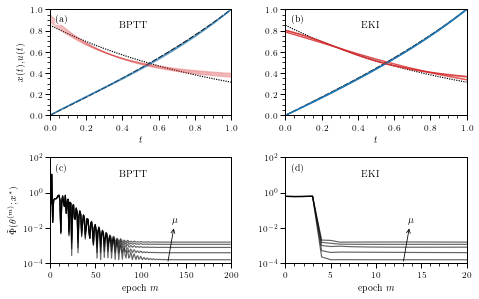

In [50]:
fig = plt.figure(constrained_layout=True)
fig.patch.set_facecolor('white')
mosaic = """
                AB
                CD
                """
ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].text(0.38,0.83,r"BPTT")
ax_dict["B"].text(0.42,0.83,r"EKI")
ax_dict["C"].text(0.38*200,0.09*1e2,r"BPTT")
ax_dict["D"].text(0.42*20,0.09*1e2,r"EKI")

ax_dict["A"].plot(t,np.sinh(t)/np.sinh(1),color="k",ls=(0, (5, 1)))
ax_dict["A"].plot(t,np.exp(-t)/np.sinh(1),color="k",ls=(0, (1, 1)))

ax_dict["B"].plot(t,np.sinh(t)/np.sinh(1),color="k",ls=(0, (5, 1)))
ax_dict["B"].plot(t,np.exp(-t)/np.sinh(1),color="k",ls=(0, (1, 1)))

for i in range(len(best_params_BPTT)):
    func = ODE_func(number_layers, number_neurons)
    func = best_params_BPTT[i]
    pred_x = odeint(func, true_x0, t, method="dopri5")

    func.output_control = True
    u_hat = np.array([float(func(x,torch.tensor([0.0]))) for x in t])
    func.output_control = False

    ax_dict["A"].plot(t,pred_x[:,0].detach(),color="tab:blue",alpha=0.3)
    ax_dict["A"].plot(t,u_hat,color="tab:red",alpha=0.3)
    
    print(1e3*mean_squared_error(np.exp(-t)/np.sinh(1),u_hat))

for i in range(len(best_params_EKI)):
    updated_params = npvec_to_tensorlist(best_params_EKI[i],nn_params)
    set_weights(func_enkf,updated_params)

    pred_x = odeint(func_enkf, true_x0, t, method='dopri5')

    func_enkf.output_control = True
    u_hat = np.array([float(func_enkf(x,torch.tensor([0.0]))) for x in t])
    func_enkf.output_control = False

    print(1e3*mean_squared_error(np.exp(-t)/np.sinh(1),u_hat))

    ax_dict["B"].plot(t,pred_x[:,0].detach(),color="tab:blue",alpha=0.6)
    ax_dict["B"].plot(t,u_hat,color="tab:red",alpha=0.6)
    
    ax_dict["C"].plot(loss_arr_BP[i],color="k",alpha=0.6)
    ax_dict["D"].plot(loss_arr_EKI[i],color="k",alpha=0.6)

ax_dict["C"].annotate(r"$\mu$", xy=(130, 1e-4), xytext=(135, 2e-2), arrowprops={"arrowstyle":"<-", "color":"k"})    
ax_dict["D"].annotate(r"$\mu$", xy=(13, 1e-4), xytext=(13.5, 2e-2), arrowprops={"arrowstyle":"<-", "color":"k"})    

text = ax_dict["A"].text(0.03*1,0.88*1,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
text = ax_dict["B"].text(0.03*1,0.88*1,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
text = ax_dict["C"].text(0.03*200,0.17*1e2,r"(c)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
text = ax_dict["D"].text(0.03*20,0.17*1e2,r"(d)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

ax_dict["A"].set_xlim(0,1)
ax_dict["A"].set_ylim(0,1)
ax_dict["A"].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax_dict["A"].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax_dict["A"].set_xlabel(r"$t$")
ax_dict["A"].set_ylabel(r"$x(t),u(t)$")

ax_dict["B"].set_xlim(0,1)
ax_dict["B"].set_ylim(0,1)
ax_dict["B"].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax_dict["B"].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax_dict["B"].set_xlabel(r"$t$")

ax_dict["C"].set_xlabel(r"epoch $m$")
ax_dict["C"].set_ylabel(r"$\tilde{\Phi}(\theta^{(m)};x^*)$")
ax_dict["C"].set_xlim(0,200)
ax_dict["C"].set_ylim(1e-4,1e2)
ax_dict["C"].xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax_dict["C"].set_yscale("log")

ax_dict["D"].set_xlabel(r"epoch $m$")
ax_dict["D"].set_xlim(0,20)
ax_dict["D"].set_ylim(1e-4,1e2)
ax_dict["D"].xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax_dict["D"].set_yscale("log")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig("bptt_vs_eki_control_icml.png",dpi=480)
plt.show()

In [76]:
len(tensorlist_to_tensor(get_weights(func_enkf)))

106